# 9 Improving performance

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Learning curves

In [4]:
from sklearn.datasets import load_digits

In [5]:
digits = load_digits()

In [6]:
X, y = digits.data, digits.target

In [7]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [8]:
X.shape

(1797, 64)

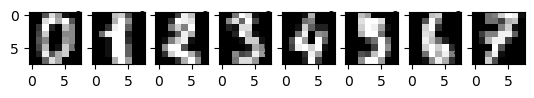

In [9]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
K.clear_session()

In [12]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

/opt/miniconda3/envs/ztdltest/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# store the initial random weights
initial_weights = model.get_weights()

In [14]:
y_cat = to_categorical(y, 10)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [17]:
X_train.shape

(1257, 64)

In [18]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [ ]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

In [ ]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

## Batch Normalization

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [ ]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

In [ ]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

In [ ]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

In [ ]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best');


## Weight Regularization & Dropout

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])

## Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

In [ ]:
train = generator.flow_from_directory('../data/generator',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

## Embeddings

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
emb = model.predict(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

In [ ]:
emb.shape

In [ ]:
emb

## Sentiment prediction on movie Reviews

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [ ]:
X_train.shape

In [ ]:
X_train[1]

In [ ]:
idx = imdb.get_word_index()

In [ ]:
max(idx.values())

In [ ]:
idx

In [ ]:
rev_idx = {v+3:k for k,v in idx.items()}

In [ ]:
rev_idx

In [ ]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [ ]:
rev_idx[3]

In [ ]:
y_train[0]

In [ ]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

In [ ]:
len(X_train[0])

In [ ]:
len(X_train[1])

In [ ]:
len(X_train[2])

In [ ]:
len(X_train[3])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM

In [ ]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [ ]:
X_train_pad.shape

In [ ]:
X_train_pad[0]

In [ ]:
X_train[0]

In [ ]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

In [ ]:
y_train

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

In [ ]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

## Exercise 1

- Reload the IMDB data keeping only the first 20000 most common words
- pad the reviews to a shorter length (eg. 70 or 80), this time make sure you keep the first part of the review if it's longer than the maximum length
- re run the model (remember to set max_features correctly)
- does it train faster this time?
- do you get a better performance?

## Exercise 2

- Reload the digits data as above
- define a function repeated_training_reg_dropout that adds regularization and dropout to a fully connected network
- compare the performance with/witouth dropout and regularization like we did for batch normalization
- do you get a better performance?

## Exercise 3

This is a very long and complex exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost. Also, feel free to run this on Floyd with a GPU, in which case you don't need to download the data.

If you are running this locally, download and unpack the male/female pictures from [here](https://www.dropbox.com/s/nov493om2jmh2gp/male_female.tgz?dl=0). These images and labels were obtained from [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

Your goal is to build an image classifier that will recognize the gender of a person from pictures.

- Have a look at the directory structure and inspect a couple of pictures
- Design a model that will take a color image of size 64x64 as input and return a binary output (female=0/male=1)
- Feel free to introduce any regularization technique in your model (Dropout, Batch Normalization, Weight Regularization)
- Compile your model with an optimizer of your choice
- Using `ImageDataGenerator`, define a train generator that will augment your images with some geometric transformations. Feel free to choose the parameters that make sense to you.
- Define also a test generator, whose only purpose is to rescale the pixels by 1./255
- use the function `flow_from_directory` to generate batches from the train and test folders. Make sure you set the `target_size` to 64x64.
- Use the `model.fit_generator` function to fit the model on the batches generated from the ImageDataGenerator. Since you are streaming and augmenting the data in real time you will have to decide how many batches make an epoch and how many epochs you want to run
- Train your model (you should get to at least 85% accuracy)
- Once you are satisfied with your training, check a few of the misclassified pictures. Are those sensible errors?